<a href="https://colab.research.google.com/github/Aakash326/ML-models/blob/main/Emotion_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-06-12 15:52:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-12 15:52:22 (107 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [3]:
import helper_functions

In [4]:
from helper_functions import make_confusion_matrix, create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [5]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

In [4]:
import zipfile
zip_ref=zipfile.ZipFile("/content/emotion_dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [6]:
walk_through_dir("/content/Users/saiaakash/Desktop/archive-7")

There are 2 directories and 1 images in '/content/Users/saiaakash/Desktop/archive-7'.
There are 7 directories and 0 images in '/content/Users/saiaakash/Desktop/archive-7/test'.
There are 0 directories and 1774 images in '/content/Users/saiaakash/Desktop/archive-7/test/happy'.
There are 0 directories and 831 images in '/content/Users/saiaakash/Desktop/archive-7/test/surprised'.
There are 0 directories and 111 images in '/content/Users/saiaakash/Desktop/archive-7/test/disgusted'.
There are 0 directories and 1233 images in '/content/Users/saiaakash/Desktop/archive-7/test/neutral'.
There are 0 directories and 1024 images in '/content/Users/saiaakash/Desktop/archive-7/test/fearful'.
There are 0 directories and 1247 images in '/content/Users/saiaakash/Desktop/archive-7/test/sad'.
There are 0 directories and 958 images in '/content/Users/saiaakash/Desktop/archive-7/test/angry'.
There are 7 directories and 1 images in '/content/Users/saiaakash/Desktop/archive-7/train'.
There are 0 directories 

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_images_grid(target_dir, target_class, n_images=9):
    # Setup the target directory
    target_folder = os.path.join(target_dir, target_class)

    # List all image files in the folder
    image_filenames = os.listdir(target_folder)

    # Safety check: don't sample more images than available
    n_images = min(n_images, len(image_filenames))

    # Pick random images
    random_images = random.sample(image_filenames, n_images)

    # Setup the plot grid (square root for a grid shape)
    grid_size = int(n_images ** 0.5)
    if grid_size ** 2 < n_images:
        grid_size += 1

    # Plot
    plt.figure(figsize=(grid_size * 3, grid_size * 3))

    for i, image_filename in enumerate(random_images):
        img = mpimg.imread(os.path.join(target_folder, image_filename))

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img)
        plt.title(f"{target_class}\n{image_filename}", fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Displayed {n_images} random images from class '{target_class}'.")

In [1]:
class_name=['angry','disgusted','fearful','happy','neutral','sad','surprised']

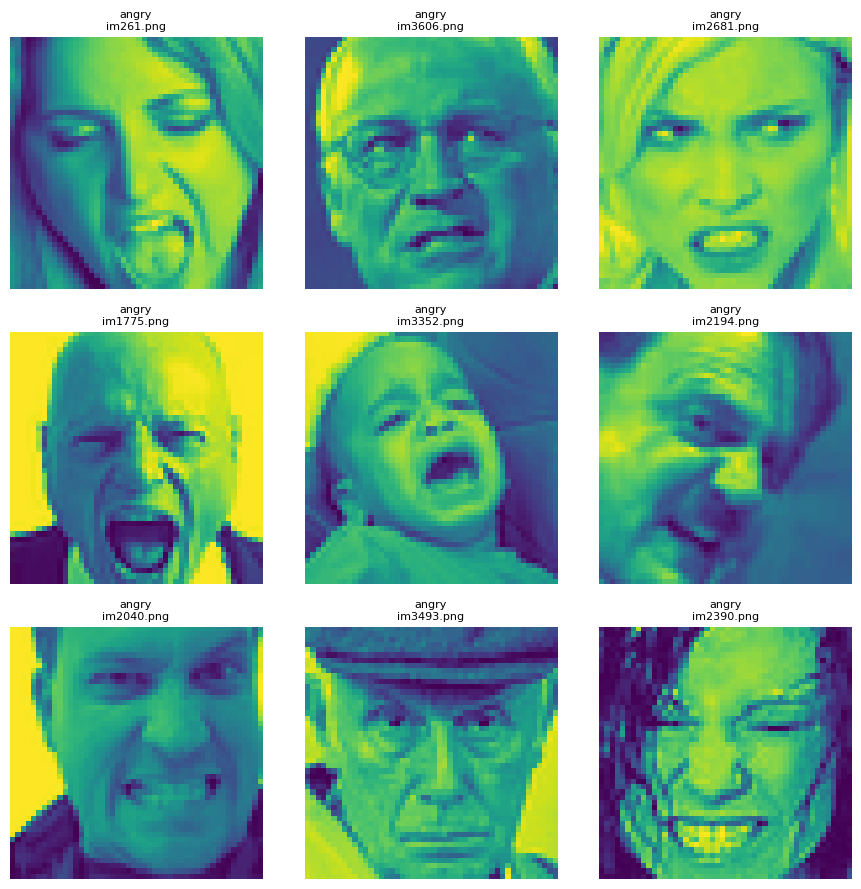

Displayed 9 random images from class 'angry'.


In [8]:
view_random_images_grid(target_dir="/content/Users/saiaakash/Desktop/archive-7/train", target_class="angry")

In [8]:
train_dir="/content/Users/saiaakash/Desktop/archive-7/train"
test_dir="/content/Users/saiaakash/Desktop/archive-7/test"

In [9]:
import tensorflow as tf
train_data = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=(224,224),
        label_mode="categorical",
        validation_split=0.2,  # Create validation split
        subset="training",
        seed=42,
        batch_size=16
    )
val_data = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        image_size=(224,224),
        label_mode="categorical",
        validation_split=0.2,
        subset="validation",
        seed=42,
        batch_size=16
    )

test_data = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        image_size=(224,224),
        label_mode="categorical",
        batch_size=16
    )

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [10]:
train_data = train_data.prefetch(buffer_size=32)
val_data = val_data.prefetch(buffer_size=32)
test_data = test_data.prefetch(buffer_size=32)

In [31]:
from tensorflow.keras.layers import RandomFlip,RandomHeight,RandomWidth,RandomZoom,RandomRotation,RandomContrast,RandomBrightness
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
data_agu=Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),  # Reduced rotation
        RandomZoom(0.1),      # Reduced zoom
        # Normalize to [0,1]

])

In [12]:
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [13]:
policy

<DTypePolicy "mixed_float16">

In [32]:
input_size = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_size
)
base_model.trainable = False

# Build model
inputs = tf.keras.Input(input_size)
x = data_agu(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Simplified and improved head
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output layer - NO mixed precision activation
outputs = layers.Dense(7, activation='softmax')(x)

model = tf.keras.models.Model(inputs, outputs)

In [33]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,  # Increased patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Less aggressive reduction
    patience=4,  # Increased patience
    min_lr=1e-6,
    verbose=1
)

In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

    # Get class distribution
y_train = []
for _, labels in train_data:
    y_train.extend(tf.argmax(labels, axis=1).numpy())

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)



Class weights: {0: np.float64(1.0196217703986505), 1: np.float64(9.03896103896104), 2: np.float64(0.998825831702544), 3: np.float64(0.5644491410877098), 4: np.float64(0.8275265717888669), 5: np.float64(0.8558014755197854), 6: np.float64(1.3177280550774526)}


In [35]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

In [18]:
initial_epochs=15

In [36]:
history1 = model.fit(
    train_data,
    epochs=initial_epochs,
    validation_data=val_data,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict,  # Use class weights
    # verbose=1
)


Epoch 1/15
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 108s 64ms/step - accuracy: 0.2359 - loss: 2.1474 - val_accuracy: 0.4071 - val_loss: 1.5621 - learning_rate: 0.0010
Epoch 2/15
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 89s 62ms/step - accuracy: 0.3275 - loss: 1.7006 - val_accuracy: 0.4339 - val_loss: 1.4944 - learning_rate: 0.0010
Epoch 3/15
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 141s 61ms/step - accuracy: 0.3528 - loss: 1.6597 - val_accuracy: 0.4221 - val_loss: 1.4979 - learning_rate: 0.0010
Epoch 4/15
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - accuracy: 0.3675 - loss: 1.6264 - val_accuracy: 0.4672 - val_loss: 1.4427 - learning_rate: 0.0010
Epoch 5/15
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 80s 56ms/step - accuracy: 0.3760 - loss: 1.6089 - val_accuracy: 0.4520 - val_loss: 1.4401 - learning_rate: 0.0010
Epoch 6/15
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.3766 - loss: 1.5972 - val_accuracy: 0.4555 - val_loss: 1.4096 - learning_rate: 0.0010
Epoch 7/15
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 149s 62ms/step - acc

In [37]:
model.evaluate(test_data)

449/449 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.4847 - loss: 1.3716


[1.364099144935608, 0.4899693429470062]

In [38]:
base_model.trainable = True

# Freeze early layers (keep 80% frozen)
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.8)

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [23]:
final_epochs=initial_epochs+20

In [ ]:
early_stopping_ft = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_ft = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Fine-tuning training
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs+5

history2 = model.fit(
    train_data,
    epochs=total_epochs,
    initial_epoch=len(history1.history['loss']),
    validation_data=val_data,
    callbacks=[early_stopping_ft, reduce_lr_ft],
    class_weight=class_weight_dict,
    verbose=1
    )

Epoch 16/25
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 112s 78ms/step - accuracy: 0.7123 - loss: 0.7063 - val_accuracy: 0.6516 - val_loss: 1.0221 - learning_rate: 2.5000e-05
Epoch 17/25
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 105s 73ms/step - accuracy: 0.7086 - loss: 0.7048 - val_accuracy: 0.6499 - val_loss: 1.0270 - learning_rate: 2.5000e-05
Epoch 18/25
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 112s 78ms/step - accuracy: 0.7153 - loss: 0.6948 - val_accuracy: 0.6542 - val_loss: 1.0244 - learning_rate: 2.5000e-05
Epoch 19/25
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 135s 73ms/step - accuracy: 0.7112 - loss: 0.7009 - val_accuracy: 0.6576 - val_loss: 1.0235 - learning_rate: 2.5000e-05
Epoch 20/25
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 113s 79ms/step - accuracy: 0.7180 - loss: 0.6936 - val_accuracy: 0.6548 - val_loss: 1.0345 - learning_rate: 2.5000e-05
Epoch 21/25
1435/1436 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7201 - loss: 0.6798
Epoch 21: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
1436/1436 ━━━━━━━━━━━━━

In [40]:
model.evaluate(test_data)

449/449 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.6632 - loss: 0.9642


[0.9814310073852539, 0.6609083414077759]

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

# Step 1: Unbatch test data to get images and labels
all_images = []
all_labels = []

for img, label in test_data.unbatch():
    all_images.append(img.numpy())
    all_labels.append(label.numpy())

# Step 2: Pick 9 random samples
random_idxs = random.sample(range(len(all_images)), 9)

# Step 3: Class names
class_names = ds_info.features["label"].names

# Step 4: Create a 3x3 plot
plt.figure(figsize=(12, 12))
for i, idx in enumerate(random_idxs):
    img = all_images[idx]
    label = all_labels[idx]

    # Preprocess and predict
    img_processed = tf.expand_dims(img, axis=0)
    pred_probs = model.predict(img_processed, verbose=0)
    pred_class = tf.argmax(pred_probs[0]).numpy()
    confidence = tf.reduce_max(pred_probs[0]).numpy()

    # Choose title color
    color = "green" if pred_class == label else "red"
    title = f"Pred: {class_names[pred_class]} ({confidence*100:.1f}%)\nTrue: {class_names[label]}"

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(title, color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


Saving Screenshot 2025-06-09 at 11.43.47 AM.png to Screenshot 2025-06-09 at 11.43.47 AM (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


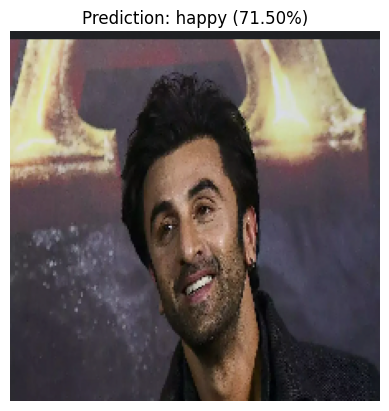

Predicted class: happy
Confidence: 71.50%


In [11]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Step 2: Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # Add batch dim
img_array = preprocess_input(img_array)        # Normalize for EfficientNet

# Step 3: Make prediction
predictions = loaded_model.predict(img_array)
predicted_class = tf.argmax(predictions[0]).numpy()
confidence = tf.reduce_max(predictions[0]).numpy()

# Step 4: Get class names (from dataset)
# Assuming the original dataset used to create train_data has a class_names attribute
# Replace 'original_dataset' with the actual variable name of your dataset
# class_names = train_data.element_spec[0].shape[-1]
class_names = ['angry','disgusted','fearful','happy','neutral','sad','surprised'] # Using the class_name variable from cell np1_qQ5RREVI

# Step 5: Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[int(predicted_class)]} ({confidence*100:.2f}%)") # Convert predicted_class to int
plt.show()

print(f"Predicted class: {class_names[int(predicted_class)]}") # Convert predicted_class to int
print(f"Confidence: {confidence*100:.2f}%")

In [49]:
model.save("emotion_model_best2.h5")

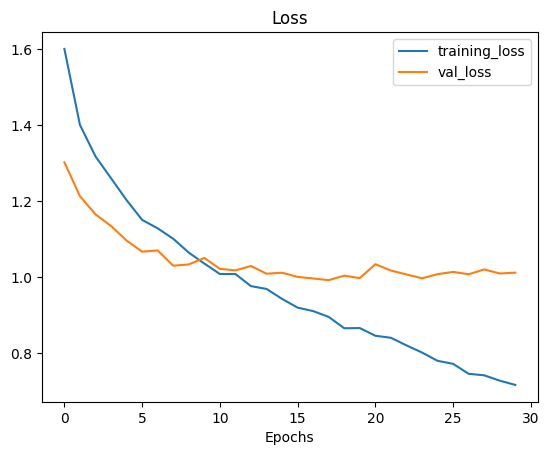

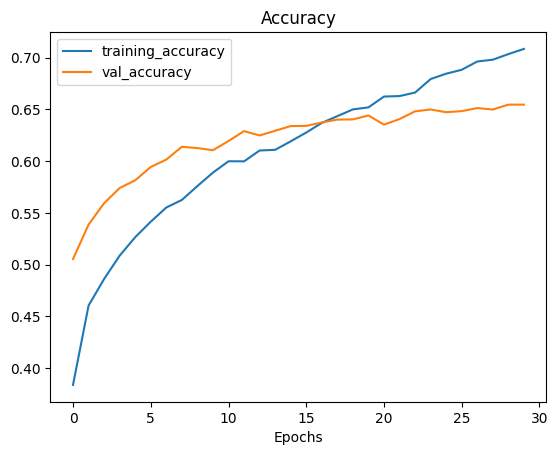

In [50]:
plot_loss_curves(history2)